In [43]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START,END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [44]:
load_dotenv()

True

In [45]:
llm = ChatGroq(model_name = "deepseek-r1-distill-llama-70b")
llm.invoke("What is the capital of France?")

AIMessage(content="<think>\nOkay, so I need to figure out what the capital of France is. Hmm, I'm not entirely sure, but I think it's a city that starts with a 'P'. Wait, no, that's maybe another country. Let me think. I remember learning about some European capitals in school. France is a big country in Western Europe, right? They speak French there. I've heard of cities like Paris and Lyon. Paris sounds familiar as a capital. But wait, I'm not 100% certain. Maybe I should recall some landmarks. The Eiffel Tower is in Paris, and I think that's the capital. Yeah, that makes sense. So I guess the capital of France is Paris.\n</think>\n\nThe capital of France is Paris.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 10, 'total_tokens': 167, 'completion_time': 0.850999002, 'prompt_time': 0.000186477, 'queue_time': 0.21743414, 'total_time': 0.851185479}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec

Implementing Human in Loop from scratch

In [46]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

In [47]:
@tool
def search(query: str) -> TavilySearchResults:
    """Searches the web for a query and return the results"""
    tavily_search = TavilySearchResults()
    result = tavily_search.invoke(query)
    
    return f"Result for {query} in \n{result}"

In [48]:
tools = [multiply, search]
llm_with_tools = llm.bind_tools(tools)

In [49]:
tool_mapping={tool.name:tool for tool in tools}

In [50]:
class AgentState(TypedDict):
    """State of the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]
    
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}
    
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

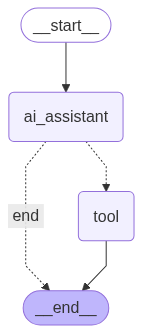

In [51]:
graph=StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)
graph.add_conditional_edges("ai_assistant", router,{"tool":"tool","end":END})
graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")

app=graph.compile()                           
app 

Inbuilt Human In Loop in LangGraph

In [52]:
llm_with_tools = llm.bind_tools(tools)

In [53]:
memory = MemorySaver()
tool_node = ToolNode(tools)

In [54]:
class AgentState(TypedDict):
    """State of the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [55]:
def ai_assistant(state:AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

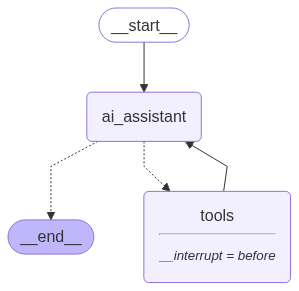

In [56]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges("ai_assistant", tools_condition)
graph_builder.add_edge("tools", "ai_assistant")

app1 = graph_builder.compile(checkpointer=memory, interrupt_before=["tools"])
app1

In [57]:
response = app1.invoke({"messages": [HumanMessage("What is the capital of France?")]}, config={"configurable": {"thread_id": "1"}})

response

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310})]}

In [59]:
snapshot = app1.get_state(config={"configurable": {"thread_id": "1"}})
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'check

In [60]:
snapshot.next

('tools',)

In [61]:
last_message = snapshot.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310})

In [62]:
tool_details = last_message.tool_calls

In [65]:
if tool_details[0]["name"] == "search":
    if input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}? ").lower() == "no":
        print("Web search tool selected.")
        raise Exception("Discarded web search by user.")
    else:
        response = app1.invoke(None, {"configurable": {"thread_id": "1"}})
        print(response)
else:
    response = app1.invoke(None, {"configurable": {"thread_id": "1"}})
    print(response)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310}), ToolMessage(content='Result for capital of France in \n[{\'title\': \'What is the Capital of France? - Mappr\'

In [67]:
tool_call_id=last_message.tool_calls[0]["id"]

In [68]:
from langchain_core.messages import AIMessage,ToolMessage

new_message=[
    ToolMessage(content="according to the latest data 4.1 trillion USD",tool_call_id=tool_call_id),
    AIMessage(content="GDP is 4.1 Trillion USD.")
    
]

config = {"configurable": {"thread_id": "1"}}
app1.update_state(config, 
                  {
                      "messages":new_message
                   }
                  )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f056d83-35ce-69ce-8004-f6d82a04fe58'}}

In [69]:
app1.get_state(config).values["messages"][-1]

AIMessage(content='GDP is 4.1 Trillion USD.', additional_kwargs={}, response_metadata={})

In [70]:
app1.invoke(None,config=config)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310}),
  ToolMessage(content='Result for capital of France in \n[{\'title\': \'What is the Capital of France? - Map

In [71]:
app1.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tt3t3r5bj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 174, 'total_tokens': 310, 'completion_time': 0.504011382, 'prompt_time': 0.01082972, 'queue_time': 0.218359997, 'total_time': 0.514841102}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--88c2e82e-e104-4d31-8efb-40fa9ad50a5c-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'tt3t3r5bj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 136, 'total_tokens': 310}),
  ToolMessage(content='Result for capital of France in \n[{\'title\': \'What is the Capital of France? - Map